In [1]:
import tomotopy as tp
import numpy as np
import pandas as pd
import re
import os
import time
import itertools
import konlpy
from kiwipiepy import Kiwi
from hanspell import spell_checker
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pyLDAvis


In [2]:
df=pd.read_csv('secondary.csv',encoding='utf-8-sig',header=0, dtype={'score':np.str})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5035 entries, 0 to 5034
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   review_title  5035 non-null   object
 1   review        5035 non-null   object
 2   score         5035 non-null   object
 3   real_date     5035 non-null   object
 4   year          5035 non-null   int64 
 5   month         5035 non-null   int64 
 6   type          4558 non-null   object
 7   dataset       4966 non-null   object
dtypes: int64(2), object(6)
memory usage: 314.8+ KB


C:\Users\jenny\AppData\Local\Temp/ipykernel_24608/3728096588.py:1: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df=pd.read_csv('secondary.csv',encoding='utf-8-sig',header=0, dtype={'score':np.str})


In [3]:
df['type'].unique()

array([' 친구', ' 커플', nan, ' 비지니스', ' 개인', ' 가족'], dtype=object)

In [4]:
for i in range(len(df)):
    if df.iloc[i,6] in [' 친구',' 가족',' 커플']:
        df.iloc[i,6] = 'no_solo'
    elif df.iloc[i,6] in [' 비지니스', np.NaN]:
        df.iloc[i,6] = np.NaN
    elif df.iloc[i,6] in [' 개인']:
        df.iloc[i,6]='solo'

In [5]:
df['type'].unique()

array(['no_solo', nan, 'solo'], dtype=object)

In [6]:
df.dropna(subset=['type'], how='any', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4293 entries, 0 to 5034
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   review_title  4293 non-null   object
 1   review        4293 non-null   object
 2   score         4293 non-null   object
 3   real_date     4293 non-null   object
 4   year          4293 non-null   int64 
 5   month         4293 non-null   int64 
 6   type          4293 non-null   object
 7   dataset       4233 non-null   object
dtypes: int64(2), object(6)
memory usage: 301.9+ KB


In [7]:
#솔로/비솔로 데이터 구분
#비솔로
condition = (df.type=='no_solo')
df2=df.loc[condition]

In [8]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3611 entries, 0 to 5034
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   review_title  3611 non-null   object
 1   review        3611 non-null   object
 2   score         3611 non-null   object
 3   real_date     3611 non-null   object
 4   year          3611 non-null   int64 
 5   month         3611 non-null   int64 
 6   type          3611 non-null   object
 7   dataset       3558 non-null   object
dtypes: int64(2), object(6)
memory usage: 253.9+ KB


In [9]:
df2.dropna(subset=['dataset'], how='any', inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3558 entries, 0 to 5034
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   review_title  3558 non-null   object
 1   review        3558 non-null   object
 2   score         3558 non-null   object
 3   real_date     3558 non-null   object
 4   year          3558 non-null   int64 
 5   month         3558 non-null   int64 
 6   type          3558 non-null   object
 7   dataset       3558 non-null   object
dtypes: int64(2), object(6)
memory usage: 250.2+ KB


C:\Users\jenny\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [10]:
#응집도 계산 전 사용할 토크나이저 함수 정의

import konlpy
stop_list=['우리','함께','있습니다']
def tokenize_korean_text(text):
    text = re.sub(r'[^,.?!\w\s]','', text)
    
    okt = konlpy.tag.Okt()
    Okt_morphs = okt.pos(text)
    
    words = []
    for word, pos in Okt_morphs:
        if not pos == 'Josa' and not pos =='Punctuation' and not pos =='Foreign' and len(word) > 1 and word not in stop_list :
            words.append(word)
    ## word를 이어붙인 string 형태가 아닌 word의 list를 return해주는 게 sklearn lda 준비 과정과의 차이
            
    return words

In [11]:
#솔로 데이터 토큰화
tokenized_list_no = []
a=df2['dataset'].values
for text in range(len(a)):
    tokenized_list_no.append(tokenize_korean_text(a[text]))

In [12]:
#솔로
model = tp.DMRModel(k=20, alpha=0.1, eta=0.01, min_cf=6,rm_top=3,tw=tp.TermWeight.IDF)

key=df2['score'].values
value=tokenized_list_no


for pairs in zip(key, value):
    try :
        model.add_doc(pairs[1],metadata=pairs[0]) # tokenize함수를 이용해 전처리한 결과를 add_doc에 넣습니다.
    except RuntimeError :
        pass
        
               
model.train(0)
print('Total docs:', len(model.docs))
print('Total words:', model.num_words)
print('Vocab size:', model.num_vocabs)
 

Total docs: 3558
Total words: 82828
Vocab size: 1913


In [13]:
model.summary()

<Basic Info>
| DMRModel (current version: 0.12.2)
| 3558 docs, 82828 words
| Total Vocabs: 10010, Used Vocabs: 1913
| Entropy of words: 6.47635
| Entropy of term-weighted words: 7.03530
| Removed Vocabs: 쇼핑 있는 음식
| Metadata of docs and its distribution
|  5: 1533
|  4: 1372
|  3: 518
|  2: 108
|  1: 27
|
<Training Info>
| Iterations: 0, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -9.95401
|
<Initial Parameters>
| tw: TermWeight.IDF
| min_cf: 6 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 3 (the number of top words to be removed)
| k: 20 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (an initial value of exponential of mean of normal distribution for `lambdas`, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic - word)
| sigma: 1.0 (standard deviation of normal 

==== Coherence : c ====
Average: 0.43201761117205023 
Per Topic: [0.44119485914707185, 0.453076496720314, 0.4633562296628952, 0.4671964108943939, 0.44317684769630433, 0.4375645726919174, 0.4597212910652161, 0.4108893912285566, 0.41359536051750184, 0.38313761055469514, 0.42497696578502653, 0.41316273659467695, 0.4015722021460533, 0.42826552093029024, 0.4352781504392624, 0.44621976017951964, 0.43092699646949767, 0.4405112683773041, 0.4102330893278122, 0.4362964630126953]


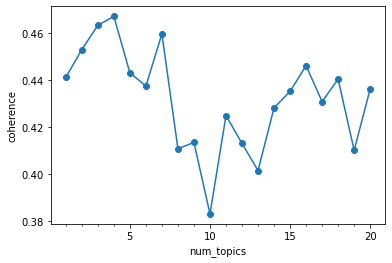

In [14]:
# calculate coherence using preset
ax=plt.axes()
coh = tp.coherence.Coherence(model, coherence='c_v')
average_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(model.k)]
print('==== Coherence : c ====')
print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
x=range(1,21,1)
plt.plot(x, coherence_per_topic,marker='o')
plt.xlabel("num_topics")
plt.ylabel("coherence")
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.show()
print()

위 결과에서 14개일 때 가장 높은 응집도를 보였기 때문에 토픽을 14개로 설정하였다.

In [15]:
#토픽수 정하고 솔로 분석
model = tp.DMRModel(k=3, alpha=0.1, eta=0.01, min_cf=6,rm_top=3,tw=tp.TermWeight.IDF)

key=df2['score'].values
value=tokenized_list_no

for pairs in zip(key, value):
    try :
        model.add_doc(pairs[1],metadata=pairs[0]) # tokenize함수를 이용해 전처리한 결과를 add_doc에 넣습니다.
    except RuntimeError :
        pass

model.train(0)
print('Total docs:', len(model.docs))
print('Total words:', model.num_words)
print('Vocab size:', model.num_vocabs)
 
 
 
for i in range(200):
    model.train(1)
    
for i in range(model.k):
    res = model.get_topic_words(i, top_n=10)
    print('Topic #{}'.format(i), end='\t')
    print(', '.join(w for w, p in res))

Total docs: 3558
Total words: 82828
Vocab size: 1913
Topic #0	외국인, 사람, 너무, 구경, 먹거리, 거리, 많고, 많이, 많아서, 전통
Topic #1	좋은, 기념품, 인사동, 가게, 많은, 상점, 지역, 가격, 전통, 한국
Topic #2	많은, 모든, 상점, 좋은, 제품, 길거리, 지역, 거리, 화장품, 경우


In [16]:
model.summary()

<Basic Info>
| DMRModel (current version: 0.12.2)
| 3558 docs, 82828 words
| Total Vocabs: 10010, Used Vocabs: 1913
| Entropy of words: 6.47635
| Entropy of term-weighted words: 7.03530
| Removed Vocabs: 쇼핑 있는 음식
| Metadata of docs and its distribution
|  5: 1533
|  4: 1372
|  3: 518
|  2: 108
|  1: 27
|
<Training Info>
| Iterations: 200, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -7.07776
|
<Initial Parameters>
| tw: TermWeight.IDF
| min_cf: 6 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 3 (the number of top words to be removed)
| k: 3 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (an initial value of exponential of mean of normal distribution for `lambdas`, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic - word)
| sigma: 1.0 (standard deviation of normal

In [17]:
#솔로 감성점수 계산
print('Topic distributions by score, solo')

df4=pd.DataFrame()
score_labels=['1','2','3','4','5']

for i in score_labels:
    df4[i+'score']=model.get_topic_prior(i)
df4['total']=df4.sum(axis=1)

total_sum=df4['total'].values
gamsung_sum=0
gamsung_list=[]

for i in range(model.k):
    a=df4.iloc[i,:-1].values
    gamsung_sum=(a[0]*1+a[1]*2+a[2]*3+a[3]*4+a[4]*5)/total_sum[i]
    gamsung_list.append(gamsung_sum)
    
df4['re_score']=gamsung_list
df4.head(20)

Topic distributions by score, solo


,1score,2score,3score,4score,5score,total,re_score
0,0.098443,0.013366,0.073769,0.051558,0.154017,0.391154,3.381794
1,0.107777,0.060481,0.017481,0.129167,0.234460,0.549366,3.586225
2,0.018713,0.014277,0.110128,0.122782,0.163989,0.429888,3.928279


In [18]:
#각 토픽 별 상위 10개 단어 추출
word_list=[]
for i in range(model.k):
    a=model.get_topic_words(i, top_n=10)
    word_list.append([x[0] for x in a])

df4['word_list']=word_list
df4.head(15)

,1score,2score,3score,4score,5score,total,re_score,word_list
0,0.098443,0.013366,0.073769,0.051558,0.154017,0.391154,3.381794,"[외국인, 사람, 너무, 구경, 먹거리, 거리, 많고, 많이, 많아서, 전통]"
1,0.107777,0.060481,0.017481,0.129167,0.234460,0.549366,3.586225,"[좋은, 기념품, 인사동, 가게, 많은, 상점, 지역, 가격, 전통, 한국]"
2,0.018713,0.014277,0.110128,0.122782,0.163989,0.429888,3.928279,"[많은, 모든, 상점, 좋은, 제품, 길거리, 지역, 거리, 화장품, 경우]"


In [19]:
 # extract candidates for auto topic labeling
extractor = tp.label.PMIExtractor(min_cf=5, min_df=5, max_len=5, max_cand=10000, normalized=True)
cands = extractor.extract(model)

labeler = tp.label.FoRelevance(model, cands, min_df=5, smoothing=1e-2, mu=0.25)
for k in range(model.k):
    print("== Topic #{} ==".format(k))
    print("Labels:", ', '.join(label for label, score in labeler.get_topic_labels(k, top_n=5)))
    for word, prob in model.get_topic_words(k, top_n=10):
        print(word, prob, sep='\t')
    print()

== Topic #0 ==
Labels: 외국인, 구경, 많아서, 먹거리, 많고
외국인	0.010998460464179516
사람	0.00827979575842619
너무	0.0081616947427392
구경	0.008159459568560123
먹거리	0.00813764613121748
거리	0.007972447201609612
많고	0.007948563434183598
많이	0.007182712201029062
많아서	0.006808917969465256
전통	0.006408387329429388

== Topic #1 ==
Labels: 경우, 지역, 상점, 또한, 다른
좋은	0.008711626753211021
기념품	0.007865034975111485
인사동	0.006851638667285442
가게	0.006659804377704859
많은	0.006442826706916094
상점	0.0063246143981814384
지역	0.006212891079485416
가격	0.005954726133495569
전통	0.005819440819323063
한국	0.005807673558592796

== Topic #2 ==
Labels: 경우, 또한, 모든, 지역, 상점
많은	0.0095104044303298
모든	0.00794180203229189
상점	0.007136486005038023
좋은	0.0068747359327971935
제품	0.006375814788043499
길거리	0.006335482466965914
지역	0.005941899958997965
거리	0.005795150529593229
화장품	0.005753632169216871
경우	0.005726854782551527



In [20]:
#빈도 구하기 전
df5=pd.DataFrame()
df5['docs']=tokenized_list_no
df5['score']=df2['score'].values
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3558 entries, 0 to 3557
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   docs    3558 non-null   object
 1   score   3558 non-null   object
dtypes: object(2)
memory usage: 55.7+ KB


In [21]:
#빈도 구하기

topic_num=[]
temp1=[] #토픽번호
temp2=[] #분포율
for i in range(len(model.docs)):
    a=model.docs[i].get_topics()
    temp1.append([x[0] for x in a])
    temp2.append([x[1] for x in a])
for i in range(len(temp1)):
    if temp2[i][0] >= 0.5:
        topic_num.append(temp1[i][0])
    else :
        topic_num.append(np.NaN)
df5['topic_num']=topic_num
df5[df5['topic_num'].isnull()]

,docs,score,topic_num
1,"[바쁜, 젊은, 패션, 전체, 관광객, 지역, 주민, 음식, 쇼핑, 패션, 유사한,...",5,NaN
3,"[거리, 길거리, 젊은, 대학생, 겨울, 딱히, 대부분, 점포, 판매, 여성, 소매...",3,NaN
20,"[나쁘지, 않음, 브로, 있는, 조금, 넘게, 했습니다, 미술, 작업, 나쁘지, 않...",3,NaN
29,"[하지, 않고, 있는, 찾을, 홍대, 놀라면, 화이트, 아웃, 계획, 가기, 했습니...",5,NaN
60,"[여행, 추억, 대학, 묵었던, 호스텔, 있고, 놀라운, 방문, 했다, 먹을, 많고...",5,NaN
...,...,...,...
3440,"[거대한, 쇼핑몰, 쇼핑, 엔터테인먼트, 레스토랑, 이는, 깨끗한, 가장, 가장, ...",4,NaN
3442,"[많은, 선택, 잠실역, 롯데, 월드, 쇼핑몰, 통해, 쉽게, 있는, 서울역, 지하...",4,NaN
3455,"[롯데, 월드, 타워, 인상, 전망대, 일몰, 있는, timed, tix, 샀다, ...",5,NaN
3547,"[모든, 있다, 영화관, 쇼핑몰, 음식점, 호텔, 모든, 갖추어진, 가까워, 자주,...",5,NaN


In [22]:
df6=df5.groupby(['topic_num','score'])['docs']
print(df6.size().reset_index(name='counts'))

    topic_num score  counts
0         0.0     1      19
1         0.0     2      70
2         0.0     3     266
3         0.0     4     438
4         0.0     5     373
5         1.0     1       5
6         1.0     2      27
7         1.0     3     126
8         1.0     4     415
9         1.0     5     470
10        2.0     1       3
11        2.0     2       8
12        2.0     3     107
13        2.0     4     480
14        2.0     5     647
